### Einführung in Natural Language Processing

Dies ist eine kleine Einführung in Natural Language Processing anhand der Freitext-Features unseres OSMI2016 Datensatzes. Wir werden uns zunächst Supervised Learning und anschließend Unsupervised Learning anschauen. 

**Natural Language Processing** ist eine Abzweigung von Machine Learning, die sich mit der Verarbeitung, Analyse und manchmal auch der Erzeugung menschlicher Sprache ("Natural Language") befasst. Das bietet sich vor allem bei großen Datensätzen an, bei denen die menschliche Bearbeitung ineffizient wäre.  Aktuelle Beispiele von Natural Language Processing sind Chatbots (z.B. Akexa, Siri). Zudem wird Sentiment Analysis gerne genutzt, um Reviews zu Produkten zu verarbeiten, oder die allgemeine Stimmung zu einem Thema herauszufinden (z.B. auf Twitter: https://monkeylearn.com/blog/sentiment-analysis-of-twitter/).  

In [1]:
import pandas as pd
import numpy as np
import string
import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig

from pathlib import Path

# Display plots inside the notebook
%matplotlib inline
sns.set(style="white", palette="pastel")

/Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


### 1. Vorbereitung des Datensatzes

In [2]:
# Datensatz einlesen und Column Names kleinschreiben

df_2016 = pd.read_csv("OSMI_2016_kurz.csv")
df_2016.columns = map(str.lower, df_2016.columns)

In [3]:
# Rename_dict aus vorherigen Analysen verwenden

rename_dict = {'are you self-employed?': "Employment", 
              'does your employer provide mental health benefits as part of healthcare coverage?':"Ment_Benefit",
              'has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': "Ment_Discuss",
               'do you think that discussing a mental health disorder with your employer would have negative consequences?': "Ment_Consequence",
               'do you think that discussing a physical health issue with your employer would have negative consequences?': "Phys_Consequence",
               'would you feel comfortable discussing a mental health disorder with your coworkers?': "Discuss_Coworkers",
               'would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': "Discuss_Supervisor",
               'do you feel that your employer takes mental health as seriously as physical health?': "Ment_vs_Phys",
               'have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': "Obs_Consequence",
               'if you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': "Reveal_Treatment",
               'do you believe your productivity is ever affected by a mental health issue?': "Productivity",
               'would you be willing to bring up a physical health issue with a potential employer in an interview?': "Interview_phys1",
               'why or why not?': "Interview_phys2",
               'would you bring up a mental health issue with a potential employer in an interview?': "Interview_psych1",
               'why or why not?.1': "Interview_psych2",
               'do you feel that being identified as a person with a mental health issue would hurt your career?': "Career_Consequence",
               'do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': "Coworkers_view",
               'how willing would you be to share with friends and family that you have a mental illness?': "Share_friends",
               'have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': "Obs_Response1",
               'have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': "Obs_Response2",
               'have you ever sought treatment for a mental health issue from a mental health professional?': "Treatment",
               'if you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': "Interferes1",
               'if you have a mental health issue, do you feel that it interferes with your work when not being treated effectively?': "Interferes2",
               'what is your age?': "Age", 
               'what is your gender?': "Gender",
               'what country do you live in?': "Country",
              }

In [4]:
# Columns mithilfe des Rename_dicts umbenennen

df = df_2016.rename(columns = rename_dict, errors = "raise")

In [5]:
# wir nehmen nur die Freitext-Spalten und die Ja/Nein Fragen ("Would you discuss a mental/physical issue...")
# in unseren NLP Datensatz auf 

df_NLP = df[["Interview_phys1", "Interview_phys2", "Interview_psych1", "Interview_psych2"]]

In [6]:
# Wie viele fehlende Werte gibt es?

df_NLP.isna().sum()

Interview_phys1       0
Interview_phys2     338
Interview_psych1      0
Interview_psych2    307
dtype: int64

In [7]:
# normalerweise nicht empfehlenswert, aber hier können wir die fehlenden Werte nicht ersetzen. 
# wir droppen also alle Zeilen, in denen es entweder bei Interview_phys2 oder Interview_psych2 fehlende Werte gibt.

df_NLP = df_NLP.dropna()

In [8]:
# Ändere die gesamten Freitexteinträge auf Kleinschrift

df_NLP = df_NLP.applymap(lambda s:s.lower() if type(s) == str else s)

### 2. Vorbereitung von Natural Language Processing

Damit wir Machine Learning auf Text-Corpora anwenden können müssen wir sie in eine **numerische Form** bringen. Dazu sind ein paar Vorbereitungsschritte notwendig. Zunächst müssen wir ein Sprachpaket herunterladen, damit wir die Wörter im Text in Wort-Tokens umwanden können (mehr dazu gleich). Die **Spacy**-Library bietet diese Sprachpakete auf verschiedenen Sprachen und Größen an. In unserem Fall laden wir das mittelgroße Englisch-Paket. 

In [9]:
# Das englische Spacy Sprach Paket müssen Sie vorher runterladen 
# https://spacy.io/usage/models
nlp = spacy.load("en_core_web_md")

### Wichtige NLP-Konzepte 1

- **Tokenization**: Ein fundamentaler Preprocessing-Step für einen Großteil der NLP-Anwendungen. Zerlegt Text-Daten in kleinere Elemente (z.B. Wörter, Sätze,...) die als diskrete Elemente gezählt werden können. In unserem Fall zerlgen wir den Text in Wörter. 
- **Lemmatisation**: Wörter werden auf ihren Grundform reduziert, z.B. "Houses" --> "House", "Thought" --> "Think" etc. 
- **Stop-Words**: Wörter, die in einer Sprache so häufig vorkommen, dass sie nicht viel Bedeutung zum Thema eines Texts beitragen. Beispiele sind "a", "the", "do" etc. In unserem Fall werden wir diese Stop-Words entfernen. 

In [10]:
# Tokenize Text Corpora 
df_NLP["Interview_phys_NLP"] = [nlp(s) for s in df_NLP["Interview_phys2"]]
df_NLP["Interview_psych_NLP"] = [nlp(s) for s in df_NLP["Interview_psych2"]]

In [11]:
df_NLP.head()

,Interview_phys1,Interview_phys2,Interview_psych1,Interview_psych2,Interview_phys_NLP,Interview_psych_NLP
1,maybe,it would depend on the health issue. if there ...,no,while mental health has become a more prominen...,"(it, would, depend, on, the, health, issue, .,...","(while, mental, health, has, become, a, more, ..."
2,yes,"they would provable need to know, to judge if ...",yes,"stigma, mainly.","(they, would, provable, need, to, know, ,, to,...","(stigma, ,, mainly, .)"
3,yes,"old back injury, doesn't cause me many issues ...",maybe,would not if i was not 100% sure that the disc...,"(old, back, injury, ,, does, n't, cause, me, m...","(would, not, if, i, was, not, 100, %, sure, th..."
4,maybe,depending on the interview stage and whether i...,no,i don't know,"(depending, on, the, interview, stage, and, wh...","(i, do, n't, know)"
5,yes,if it would potentially affect my ability to d...,maybe,it would depend on the field & what i knew of ...,"(if, it, would, potentially, affect, my, abili...","(it, would, depend, on, the, field, &, what, i..."


#### Explorative Datenanalyse

In [12]:
# show universal pos (=part of speech) tags
for corpus in df_NLP.Interview_psych_NLP[:1]:
    print(' '.join('{word}/{tag}'.format(word=t.orth_, tag=t.pos_) for t in corpus))

while/ADP mental/ADJ health/NOUN has/VERB become/VERB a/DET more/ADV prominent/ADJ issue/NOUN recently/ADV ,/PUNCT i/PRON feel/VERB like/ADP there/ADV is/VERB still/ADV a/DET lot/NOUN of/ADP stigma/NOUN surrounding/VERB it/PRON ./PUNCT at/ADP this/DET point/NOUN ,/PUNCT with/ADP our/DET culture/NOUN ,/PUNCT i/PRON would/VERB not/ADV bring/VERB it/PRON up/PART ./PUNCT i/PRON hope/VERB that/ADP within/ADP the/DET next/ADJ 20/NUM -/SYM 30/NUM years/NOUN that/DET stigma/NOUN will/VERB be/VERB gone/VERB and/CCONJ it/PRON can/VERB be/VERB brought/VERB up/PART safely/ADV in/ADP an/DET interview/NOUN ./PUNCT


In [13]:
# show dependency arcs
for corpus in df_NLP.Interview_psych_NLP[2:3]:
    print('\n'.join('{child:<8} <{label:-^7} {head}'.format(child=t.orth_, \
                                                            label=t.dep_, head=t.head.orth_) for t in corpus))

would    <-ROOT-- would
not      <--neg-- would
if       <-mark-- was
i        <-nsubj- was
was      <-advcl- not
not      <--neg-- was
100      <nummod- %
%        <npadvmod sure
sure     <-acomp- was
that     <-mark-- affect
the      <--det-- disclosure
disclosure <-nsubj- affect
would    <--aux-- affect
not      <--neg-- affect
affect   <-ccomp- sure
my       <-poss-- application
application <-dobj-- affect


In [14]:
# Show named entities 

spacy.displacy.render(df_NLP.Interview_psych_NLP[1], style='ent',jupyter=True)

#### Tokenization & Lemmatization

Die nachfolgende Funktion wendet Tokenization und Lemmatization auf unsere Text Corpora an und entfern Stop-Words und Satzzeichen. 

In [15]:
def spacify_my_text(text, custom_stop=None, lemmatize=True):
    ''' Loops through list of text-corpora, tokenizes and lemmatizes words and
    removes stop words and punctutations.
    Returns lemmatized list of words'''

    spacyfied = []
    original = list(nlp.Defaults.stop_words) # list of stop words
    original.append(' ') # adds space to stop word list
    for p in string.punctuation: # adds punctuations to stop-list to remove them
        original.append(p)

    if custom_stop: # adds custom stop words to basic list
        for i in custom_stop:
            if i not in original:
                original.append(i)

    parsed_sentence = nlp(text.lower())
    treated_sentence = ''

# With SpaCy we can access each word’s base form with a token’s .lemma_ method

    for token in parsed_sentence:
        if str(token) not in original:
            if lemmatize:
                treated_sentence += str(token.lemma_) + ' '
            else:
                treated_sentence += str(token) + ' '
    spacyfied.append(treated_sentence.strip())

    return spacyfied

In [16]:
# Wende die spacify_my_text Funktion auf unsere Freitext-Variablen an
# Ich ergänze hier "100" zur Stop-List

custom_stop= ["100"]

df_NLP["Psych_spacified"] = df_NLP["Interview_psych2"].apply(lambda s:spacify_my_text(s, custom_stop=custom_stop))
df_NLP["Phys_spacified"] = df_NLP["Interview_phys2"].apply(lambda s:spacify_my_text(s,custom_stop=custom_stop))

In [17]:
df_NLP.head()

,Interview_phys1,Interview_phys2,Interview_psych1,Interview_psych2,Interview_phys_NLP,Interview_psych_NLP,Psych_spacified,Phys_spacified
1,maybe,it would depend on the health issue. if there ...,no,while mental health has become a more prominen...,"(it, would, depend, on, the, health, issue, .,...","(while, mental, health, has, become, a, more, ...",[mental health prominent issue recently feel l...,[depend health issue health issue immediately ...
2,yes,"they would provable need to know, to judge if ...",yes,"stigma, mainly.","(they, would, provable, need, to, know, ,, to,...","(stigma, ,, mainly, .)",[stigma mainly],[provable need know judge job]
3,yes,"old back injury, doesn't cause me many issues ...",maybe,would not if i was not 100% sure that the disc...,"(old, back, injury, ,, does, n't, cause, me, m...","(would, not, if, i, was, not, 100, %, sure, th...",[sure disclosure affect application],[old injury cause issue occasionally impact ab...
4,maybe,depending on the interview stage and whether i...,no,i don't know,"(depending, on, the, interview, stage, and, wh...","(i, do, n't, know)",[know],[depend interview stage require accommodation]
5,yes,if it would potentially affect my ability to d...,maybe,it would depend on the field & what i knew of ...,"(if, it, would, potentially, affect, my, abili...","(it, would, depend, on, the, field, &, what, i...",[depend field know employer],[potentially affect ability job require specia...


#### Wordcloud für unsere "Psychological Issue" Variable 

In [18]:
wordcloud_psych = df_NLP["Psych_spacified"].tolist()
wordcloud_psych = [item for sublist in wordcloud_psych for item in sublist]
wordcloud_psych = ' '.join(wordcloud_psych)

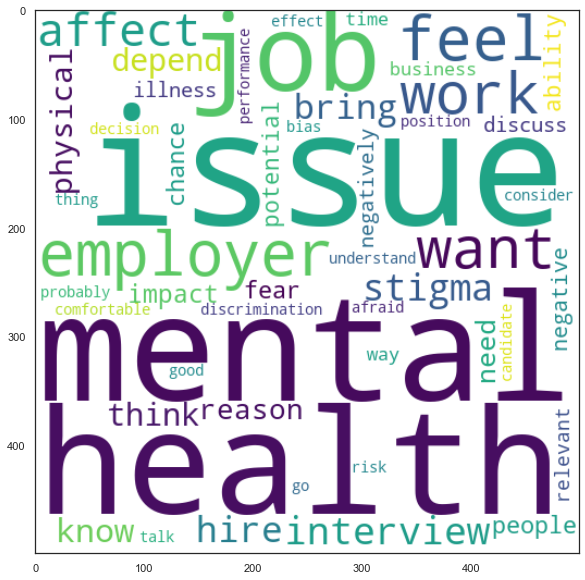

In [19]:
mask = np.zeros((500, 500, 3), np.uint8)
mask[50:70, 50:70,:] = 255  # masked out area
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                mask=mask,
                collocations= False,  # calculates frequencies
                contour_color='steelblue').generate(wordcloud_psych)
                # stop words are removed!

plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.savefig('cloud.png')
plt.show()

#### Wordcloud für unsere "Physiological Issue" Variable 

In [20]:
wordcloud_phys = df_NLP["Phys_spacified"].tolist()
wordcloud_phys = [item for sublist in wordcloud_phys for item in sublist]
wordcloud_phys = ' '.join(wordcloud_phys)

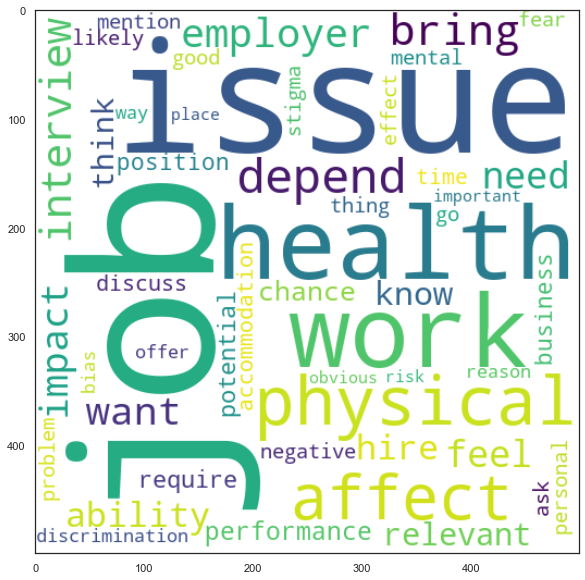

In [21]:
mask = np.zeros((500, 500, 3), np.uint8)
mask[50:70, 50:70,:] = 255  # masked out area
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                mask=mask,
                collocations= False,  # calculates frequencies
                contour_color='steelblue').generate(wordcloud_phys)
                # stop words are removed!

plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.savefig('cloud.png')
plt.show()

### Wichtige NLP-Konzepte 2

Nach der Vorverarbeitung müssen wir den Text in einen aussagekräftigen Vektor/Array von Zahlen umwandeln. Die **Bag-of-Words** Methode ist eine Repräsentation, die das Vorkommen von Worten in einem Dokument beschreibt. Dabei stellt das Vokabular von Wörtern die Features/Spalten dar, während jede Zeile ein Text-Corpus ist. 

Die Einträge in der Matrix sind dann ein Maß für das Vorkommen der Wörter, meist entweder die absolute Anzahl oder lediglich das binäre Vorkommen (Ja/Nein). Warum wird es "Bag of Words" genannt? Weil jegliche Information über die Struktur oder Reihenfolge der Wörter in den Texten verworfen wird und sich das Modell nur darauf bezieht ob/ wie oft ein Wort in den Texten vorkommt. 

Ein Problem beim "Bag of Words"-Ansatz besteht darin, dass hochfrequente Wörter anfangen, im Dokument zu dominieren, aber möglicherweise nicht so viel "Informationsgehalt" haben. Außerdem wird dadurch längeren Texten mehr Gewicht verliehen als kürzeren Texten.

Ein Ansatz besteht darin, die Häufigkeit von Wörtern danach zu skalieren, wie oft sie in allen Dokumenten vorkommen, so dass die Punktzahlen für häufige Wörter wie "Person", die ebenfalls häufig in allen Dokumenten vorkommen, geringer werden. Dieser Ansatz zur Bewertung wird Term-Frequency-Inverse Document Frequency, oder kurz **TF-IDF**, genannt. Dabei gilt:
- Term Frequency: is a scoring of the frequency of the word in the current document
- TF = (Number of times term t appears in a document)/(Number of terms in the document)
- Inverse Document Frequency: is a scoring of how rare the word is across documents.
- IDF = 1+log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

In [22]:
X_psych = df_NLP.Psych_spacified.tolist()
X_psych = [item for sublist in X_psych for item in sublist]
X_phys = df_NLP.Phys_spacified.tolist()
X_phys = [item for sublist in X_phys for item in sublist]

#### Count Vectorizer/ Bag of Words

In [23]:
cv_psych = CountVectorizer(min_df=1)
X_psych_cv= cv_psych.fit_transform(X_psych)

In [24]:
cv = CountVectorizer(min_df=1)
X_phys_cv= cv.fit_transform(X_phys)

#### TF-IDF Transformer

In [25]:
tf_ps= TfidfVectorizer(min_df=1)
X_psych_tf= tf_ps.fit_transform(X_psych)

In [26]:
tf_ph= TfidfVectorizer(min_df=1)
X_phys_tf= tf_ph.fit_transform(X_phys)

In [27]:
first_vector_psych=X_psych_tf[2]

In [28]:
first_vector_phys=X_phys_tf[2]

In [29]:
# show calculated weights of word importance: Psychological Issues
tdf = pd.DataFrame(first_vector_psych.T.todense(), index=tf_ps.get_feature_names(), columns=["tfidf"])
tdf.sort_values(by=["tfidf"],ascending=False)

,tfidf
disclosure,0.608026
application,0.570590
sure,0.454922
affect,0.312693
present,0.000000
...,...
fair,0.000000
fail,0.000000
factor,0.000000
fact,0.000000


In [30]:
# show calculated weights of word importance: Physiological Issues
tdf = pd.DataFrame(first_vector_phys.T.todense(), index=tf_ph.get_feature_names(), columns=["tfidf"])
tdf.sort_values(by=["tfidf"],ascending=False)

,tfidf
old,0.468623
occasionally,0.442517
injury,0.397889
desk,0.379367
cause,0.343337
...,...
example,0.000000
exam,0.000000
exactly,0.000000
exact,0.000000


## 3. Supervised Text Classification vs. Unsupervised Clustering

**Supervised Text Classification** ist ein Problem, bei dem wir eine feste Anzahl von Klassen/Kategorien haben und jeder Text einer diese Kategorien zugeordnet wird. 

Im Gegensatz dazu gibt es beim **Unsupervised Text Clustering** keine vorgegebenen Klassen/Kategorien. Das Clustering verfolgt dabei das Ziel, die Texte so zu gruppieren, dass Texte im selben Cluster einander ähnlicher sind als Texte in anderen Clustern. Das Modell deckt verborgene Strukturen innerhalb und zwischen den Dokumenten auf - es ist die Aufgabe der Analytiker diese Informationen ensprechend zu interpretieren und die Kategorien zu benennen. 

Wir beginnen zunächst mit Supervised Classification, indem wir ein Modell trainieren anhand der Freitext-Inputs vorherzusagen, ob man seinen Vorgesetzten von einer psychischen Erkrankung erzählen würde (ja/nein/vielleicht).

**y**: 'would you bring up a mental health issue with a potential employer in an interview?' (Yes/Maybe/No)

**X**: 'Why or why not' (Freitext)

## 3.1 Text classification (Supervised)

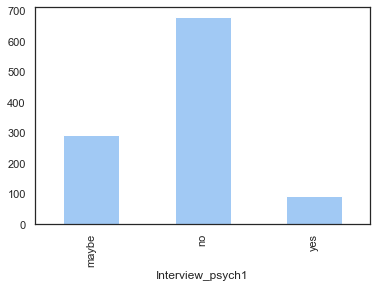

In [31]:
# Leider extrem große Class Imbalance --> könnte problematisch werden
df_NLP.groupby("Interview_psych1")["Interview_psych1"].count().plot(kind="bar")

In [32]:
df_NLP["X_psych"] = X_psych

In [33]:
# Lege X und y fest und erstelle einen Train-Test-Split

X= df_NLP['X_psych']
y= df_NLP['Interview_psych1']

Xtrain, Xtest, ytrain, ytest= train_test_split(X,y,random_state=35, test_size=0.4)

### Apply Vectorization and TF-IDF transformation to Xtrain and Xtest

In [34]:
cv = CountVectorizer(min_df= 1)
Xtrain_cv= cv.fit_transform(Xtrain)

tf= TfidfTransformer()
Xtrain_tf= tf.fit_transform(Xtrain_cv)

In [35]:
# Hier müssen wir nur transformen, da der Count Vectorizer und der TFIDF-Vectorizer an unserem Train Datensatz gefittet wurde
Xtest_cv= cv.transform(Xtest)
Xtest_tf= tf.transform(Xtest_cv)

### Fit a Multinomial Naive Bayes model on our transformed vector (X) and Response labels (y) and predict Response for Xtest

Naive Bayes bezeichnet eine Reihe von Algorithmen, mit denen Kategorien vorhergesagt werden können. Diese basieren auf die Anwendung des Bayes-Theorems, mit der (naiven) Annahme, dass jedes Merkmal unabhängig von den anderen ist. Naive Bayes sind probabilistische Classifier, d.h. die Wahrscheinlichkeit, dass ein Input in eine bestimmte Kategorie fällt wird für jede Kategorie berechnet. Der Output des Modells ist dann die Kategorie, mit der höchsten Wahrscheinlichkeit. 

Naive Bayes Classifier sind relativ simpel, aber dennoch schnell und verhältnismäßig präzise - ein optimales Einstiegsmodell!

Möchten Sie selber einen Naive Bayes Classifier bauen? Dieses Tutorial zeigt ihnen, wie es geht:
https://chrisalbon.com/machine_learning/naive_bayes/naive_bayes_classifier_from_scratch/

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

m = MultinomialNB(alpha=1.0)
m.fit(Xtrain_tf, ytrain)
ypred= m.predict(Xtest_tf) #predictions
proba= m.predict_proba(Xtest_tf) #probabilities

In [37]:
# Das Ergebnis zeigt die Precision Scores für unsere 3 Klassen. Wir sehen, dass die Precision für die "Yes" Klasse
# 0 ist - das liegt in diesem Fall daran, dass in unserem zufällig gewählten Prediction Datensatz keine "Yes" Kategorie enthalten ist,
precision_score(ytest, ypred, average=None, zero_division=0)

array([1.        , 0.69230769, 0.        ])

In [38]:
recall_score(ytest, ypred, average=None)

array([0.18699187, 1.        , 0.        ])

In [39]:
f1_score(ypred, ytest, average=None)

array([0.31506849, 0.81818182, 0.        ])

In [40]:
m.score(Xtest_tf, list(ytest))

0.7089201877934272

In [41]:
compare= pd.DataFrame(zip(list(ytest), list(Xtest), list(proba[:,0]), list(proba[:,1]),list(proba[:,2])), index= list(ypred), 
                      columns= ['actual_categorie', 'text', 'prob_no', 'prob_maybe', 'prob_yes'])

Die hohe **Class Imbalance** führt dazu, dass das Modell dazu geneigt ist, die stärker vertretene Klasse mit höherer Wahrscheinlichkeit vorherzusagen. Lösungen, die Sie ausprobieren können: unterrepräsentierte Kategorie upsamplen (z.B. Kategorie "Yes" und "Maybe" zusammenfügen), oder überrepräsentierte Kategorie downsamplen (Nur empfehlenswert, bei extrem großen Datensätzen. I.d.R. versucht man alle vorhandenen Datenpunkte zu nutzen). 

## 3.2 Unsupervised Text Clustering

Beim Unsupervised Text Clustering haben wir keine vorgegebenen Klassen/Kategorien. Wir versuchen also, mithilfe von Machine Learning Themen in den Daten zu finden. 

Der am weitesten verbreitete und einfachste Clustering-Algorithmus, den es gibt, ist das **K-Means-Clustering**. Bei diesem Algorithmus teilen Sie den Algorithmen mit, wie viele mögliche Cluster (oder K) es im Datenbestand gibt. Der Algorithmus verschiebt dann iterativ die k-Zentren und wählt die Datenpunkte aus, die diesem Centroid im Cluster am nächsten liegen. Die Eingaben in den Algorithmus sind die Anzahl der Cluster Κ und der Datensatz. Der Datensatz ist eine Sammlung von Merkmalen für jeden Datenpunkt. Der Algorithmus beginnt mit ersten Schätzungen für die K Centroids, die entweder zufällig generiert oder zufällig aus dem Datensatz ausgewählt werden können. Der Algorithmus iteriert dann zwischen zwei Schritten:

1. **Data assignment Step**: Jeder Centroid definiert eines der Cluster. In diesem Schritt wird jeder Datenpunkt seinem nahesten Centroid zugewiesen (die "Nähe" basiert auf der quadrierten Euclidean Distance)

2. **Centroid Update Step**: In diesem Schritt werden die Centroide neu berechnet, indem der Mittelwert aller Datenpunkte, die diesem Centroid zugeordnet sind, gebildet wird. 

Der Algorithmus iteriert zwischen den Schritten eins und zwei, bis ein Abbruchkriterium erfüllt ist (z.B. keine Datenpunkte ändern die Cluster oder eine bestimmte maximale Anzahl von Iterationen wird erreicht).

In [45]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_psych_tf)
    Sum_of_squared_distances.append(km.inertia_)

Mit steigendem k tendiert die Summe der quadrierten Distanz gegen Null. Stellen Sie sich vor, wir setzen k auf seinen Maximalwert n (wobei n die Anzahl der Stichproben ist), dann bildet jede Stichprobe ihren eigenen Cluster, was bedeutet, dass die Summe der quadrierten Abstände gleich Null ist. In diesem Fall haben wir keine optimale Elbow Curve. Wir sehen aber einen leichten Knick bei 3 Clustern. 

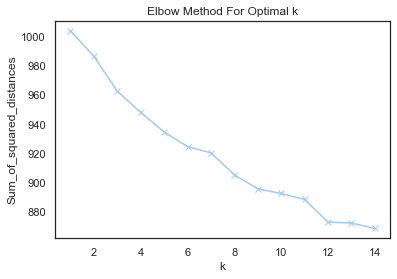

In [46]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [47]:
# predefine 3 situation categories
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
model.fit(X_psych_tf)

KMeans(n_clusters=3)

In [48]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tf_ps.get_feature_names()

Die folgenden drei Cluster wurden aus den Textdaten extrahiert. Es liegt nun an uns, diese Cluster zu Themen/ Kategorien zusammenzusammen.

In [49]:
for i in range(true_k):
    print("Cluster %d:" %i)
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])

Cluster 0:
 job
 issue
 health
 mental
 hire
 affect
 work
 depend
 feel
 want
Cluster 1:
 stigma
 negative
 avoid
 want
 mainly
 carry
 social
 maybe
 topic
 job
Cluster 2:
 reason
 physical
 health
 know
 issue
 want
 job
 productive
 employer
 hire


### Latent Dirichlet Allocation Model


LDA ist ein bag-of-words Algorithmus, der uns hilft, automatisch Themen in einem Set von Text-Dokumenten aufzuspüren. Dazu ein Beispiel:

- I wish I had a Lexus to drive to the game next week
- My trusty Honda needs an oil change
- Becky needs the Honda to go pick up the desk
- Jimmy fell off his chair laughing
- John put the couch and desk up for sale on eBay

Wenn Sie gezwungen wären, zwei Themen (Thema A und B) zu wählen, könnten Sie die Topic Representation über die Sätze hinweg folgendermaßen verteilen:

- Sentence 1 & 2: 100% about topic A
- Sentence 4 & 5: 100% about topic B
- Sentence 3: 50% topic A, 50% topic B

Die Wortverteilung über die Themen für alle Sätze gliedert sich weiter auf:

- Topic A: 25% Honda, 15% Lexus, 15% drive, 15% oil change 
- Topic B: 30% Desk, 20% chair, 20% couch 

Wir können interpretieren, dass es sich bei Thema A um Autos und bei Thema B um Möbel handelt. Mit der LDA können wir diese Themen automatisch finden. 
Textdokumente sind immer eine Mischung aus verschiedenen Themen, und innerhalb dieser Themen treten bestimmte Wörter mit einer bestimmten Wahrscheinlichkeit auf. Das Herzstück der LDA ist eine **Dirichlet-Verteilung** - eine Wahrscheinlichkeitsverteilung, ähnlich wie z.B. die Normalverteilung.

Jedes Dokument stellt eine Wahrscheinlichkeitsverteilung von Themen und jedes Thema stellt eine Wahrscheinlichkeitsverteilung von bestimmten Wörtern dar.

In [50]:
# Wählen Sie die Anzahl von Themen aus, die Sie in Ihren Textdokumenten vermuten
NUM_TOPICS = 3

# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
X_lda = lda.fit_transform(X_psych_cv)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [51]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, topic_n):
    print(f"Extracted Topic for model:{model}")
    for idx, topic in enumerate(model.components_):
        print(f"Topic:{idx}")
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-topic_n - 1:-1]])

In [52]:
selected_topics(lda, cv_psych, NUM_TOPICS)

Extracted Topic for model:LatentDirichletAllocation(learning_method='online', n_components=3,
                          verbose=True)
Topic:0
[('stigma', 43.72484173079018), ('ask', 13.779898342315793), ('time', 13.197901104388118)]
Topic:1
[('reason', 63.0118412812216), ('work', 45.22771992414082), ('affect', 40.1144005427503)]
Topic:2
[('mental', 245.35675599099625), ('health', 240.32890228149063), ('issue', 237.58848717796778)]


In [53]:
# Display Topics
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, X_psych_cv, cv_psych, mds='tsne')
dash

/Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  61.461996
1      -387.996002  -373.316162       2        1  24.600448
0     -2184.745605   -60.565800       3        1  13.937555, topic_info=     Category        Freq    Term       Total  loglift  logprob
749   Default  210.000000  mental  210.000000  30.0000  30.0000
1138  Default   80.000000  stigma   80.000000  29.0000  29.0000
545   Default  208.000000  health  208.000000  28.0000  28.0000
976   Default   53.000000  reason   53.000000  27.0000  27.0000
660   Default  164.000000     job  164.000000  26.0000  26.0000
...       ...         ...     ...         ...      ...      ...
105    Topic3    3.981707   avoid    9.191327   1.1340  -5.4683
524    Topic3    4.398569      go   17.871928   0.5686  -5.3687
543    Topic3    3.995407    have    9.912469   1.0619  -5.4648
855    Topic3    4.727306  people   38.356291  -0.1230  -5.2966
561    Topic3    4.091819    hire   76.882443  -0.9627  -5.4410

[182 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5         1  0.893131        ability
5         2  0.086432        ability
11        3  0.938579         accept
14        1  0.080589  accommodation
14        2  0.886484  accommodation
...     ...       ...            ...
1317      2  0.832699           will
1325      1  0.555581           work
1325      2  0.434803           work
1325      3  0.012078           work
1331      1  0.988146        worried

[219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])